In [1]:
#Importing
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Data Loading and Reading**

In [ ]:
# 1. Loading the Box Office Mojo (CSV) file
bom = pd.read_csv("../Data/bom.movie_gross.csv")
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [19]:
bom.shape

(3387, 5)

In [21]:
#2. Loading budgets and grosses
tn = pd.read_csv("../Data/tn.movie_budgets.csv")
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [22]:
tn.shape

(5782, 6)

In [ ]:
#3. Connecting to the IMDB database 
conn = sqlite3.connect("../im.db/im.db")
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [16]:
movie_basics  = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [18]:
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [23]:
conn.close()

**Cleaning the Budget & Gross Data**

In [24]:
#Cleaned copy
tn_clean = tn.copy()

In [ ]:
#Checking for null values
tn_clean.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
profit               0
dtype: int64

In [25]:
#Removing dollar signs ($) and commas (,) from money columns,
#Converting them from text to numbers (float type)
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )


In [26]:
#Creating a 'profit' column
# Profit = worldwide gross - production budget
tn_clean["profit"] = tn_clean["worldwide_gross"] - tn_clean["production_budget"]

In [27]:
#Cleaning up movie names to make them lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()

In [28]:
tn_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,5,"Dec 15, 2017",star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08


In [40]:
#Checking for duplicates
duplicate_count = tn_clean.duplicated().sum()
duplicate_count

0

In [30]:
tn_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,profit
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,5.989970e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,1.460889e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,-2.002376e+08
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,-2.189071e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,8.550286e+06
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,6.096850e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09


**Loading and Cleaning IMDB Data**

In [42]:
#Connecting to the IMDB database
conn = sqlite3.connect("../im.db/im.db")

In [43]:
#Reading only the columns we need from the two main tables
movie_basics = pd.read_sql("SELECT primary_title, start_year, genres FROM movie_basics;", con)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

In [44]:
#Closing the connection
conn.close()

In [45]:
#Clean movie titles
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [46]:
#Replace any missing genres with "Unknown"
movie_basics["genres"] = movie_basics["genres"].fillna("Unknown")

In [47]:
#Rename rating columns for consistency (some versions use averagerating, numvotes)
movie_ratings = movie_ratings.rename(columns={
    "averagerating": "average_rating",
    "numvotes": "num_votes"
})

In [49]:
#Show quick info about both tables
print("movie_basics loaded and cleaned:")
print(movie_basics.head())

print("\n movie_ratings loaded:")
print(movie_ratings.head())

print("\nShapes → Basics:", movie_basics.shape, " | Ratings:", movie_ratings.shape)

movie_basics loaded and cleaned:
                     primary_title  start_year                genres
0                        sunghursh        2013    Action,Crime,Drama
1  one day before the rainy season        2019       Biography,Drama
2       the other side of the wind        2018                 Drama
3                  sabse bada sukh        2018          Comedy,Drama
4         the wandering soap opera        2017  Comedy,Drama,Fantasy

 movie_ratings loaded:
     movie_id  average_rating  num_votes
0  tt10356526             8.3         31
1  tt10384606             8.9        559
2   tt1042974             6.4         20
3   tt1043726             4.2      50352
4   tt1060240             6.5         21

Shapes → Basics: (146144, 3)  | Ratings: (73856, 3)


# Merge The Numbers (budgets) with IMDB (genres + ratings)

**Merging TN and IMDB Data**

In [ ]:
# Making sure both title columns are lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [51]:
# Merging using movie title as the key
merged = pd.merge(
    tn_clean,
    movie_basics,
    left_on="movie",
    right_on="primary_title",
    how="inner"   # keeps only movies that appear in both datasets
)

In [52]:
merged.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,primary_title,start_year,genres
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,avatar,2011,Horror
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,pirates of the caribbean: on stranger tides,2011,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,dark phoenix,2019,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,avengers: age of ultron,2015,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",avengers: infinity war,300000000.0,678815482.0,2.048134e+09,1.748134e+09,avengers: infinity war,2018,"Action,Adventure,Sci-Fi"


# Objective 1: Which genres are the most expensive to produce?

In [54]:
# Make sure the 'genres' column exists and is clean
merged["genres"] = merged["genres"].fillna("Unknown")

In [55]:
# Split multiple genres (e.g., "Action,Adventure") and take the first one only for simplicity
merged["main_genre"] = merged["genres"].apply(lambda x: x.split(",")[0])

In [56]:
# Group by genre and find the average and median production budget
genre_budget = merged.groupby("main_genre")["production_budget"].agg(["mean", "median", "count"]).sort_values("mean", ascending=False)

In [57]:
# Display summary table
print("Average and Median Production Budgets by Genre:")
print(genre_budget.head(10))

Average and Median Production Budgets by Genre:
                    mean      median  count
main_genre                                 
Adventure   6.340403e+07  40000000.0    254
Action      6.183072e+07  38000000.0    726
Fantasy     4.490860e+07  25000000.0     22
Animation   4.088416e+07  27500000.0     40
War         4.000000e+07  45000000.0      4
Family      3.841557e+07  10100000.0     25
Unknown     3.299690e+07  15000000.0     73
Sport       3.066667e+07  25000000.0      3
Musical     3.053750e+07  11450000.0      8
Mystery     3.024474e+07  25000000.0     19


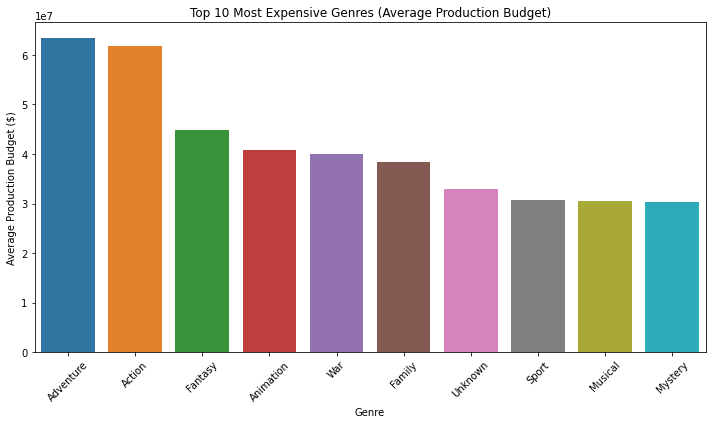

In [58]:
# Visualization — Top 10 most expensive genres
plt.figure(figsize=(10,6))
sns.barplot(x=genre_budget.head(10).index, y=genre_budget.head(10)["mean"])
plt.title("Top 10 Most Expensive Genres (Average Production Budget)")
plt.xlabel("Genre")
plt.ylabel("Average Production Budget ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Objective 2 — Best Performing Genres

In [60]:
# Make sure we have a single genre column (from Objective 1)
merged["main_genre"] = merged["genres"].fillna("Unknown").apply(lambda x: x.split(",")[0])

In [62]:
# Group by genre and calculate total and average worldwide gross
genre_gross = (
    merged.groupby("main_genre")[["worldwide_gross", "profit"]]
    .agg(total_gross=("worldwide_gross", "sum"),
         avg_gross=("worldwide_gross", "mean"),
         avg_profit=("profit", "mean"),
         movie_count=("profit", "count"))
    .sort_values("total_gross", ascending=False)
)

In [64]:
# Display summary table
print("Total and Average Gross by Genre:")
print(genre_gross.head(10))

Total and Average Gross by Genre:
              total_gross     avg_gross    avg_profit  movie_count
main_genre                                                        
Action       1.265210e+11  1.742714e+08  1.124407e+08          726
Adventure    5.554669e+10  2.186878e+08  1.552837e+08          254
Drama        4.832007e+10  4.945759e+07  2.923838e+07          977
Comedy       3.311125e+10  5.689219e+07  3.583591e+07          582
Documentary  2.445498e+10  6.206848e+07  3.694303e+07          394
Horror       1.639589e+10  7.222858e+07  5.443919e+07          227
Biography    1.423660e+10  6.441902e+07  4.019372e+07          221
Crime        8.265278e+09  4.919809e+07  2.729400e+07          168
Family       7.226768e+09  2.890707e+08  2.506552e+08           25
Unknown      6.944128e+09  9.512504e+07  6.212814e+07           73


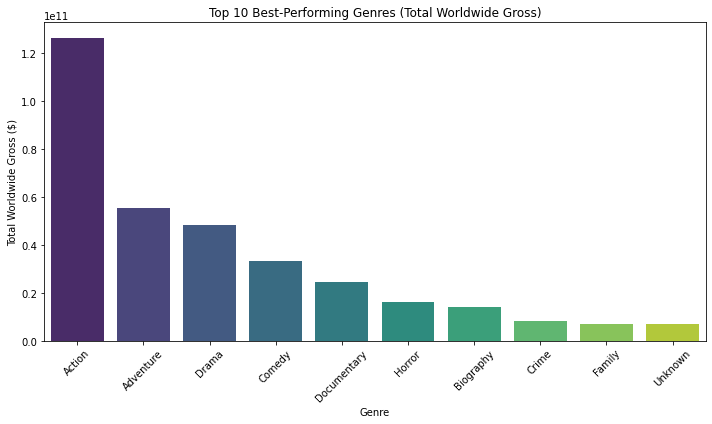

In [65]:
# Visualization – Top 10 Best-Performing Genres
plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_gross.head(10).index,
    y=genre_gross.head(10)["total_gross"],
    palette="viridis"
)
plt.title("Top 10 Best-Performing Genres (Total Worldwide Gross)")
plt.xlabel("Genre")
plt.ylabel("Total Worldwide Gross ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Objective 3 — Effect of Budget on Profit